# Autoencoders and GANs

### Import Libraries

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")
    if IS_KAGGLE:
        print("Go to Settings > Accelerator and select GPU.")

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

2023-10-30 08:06:38.303316: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


No GPU was detected. LSTMs and CNNs can be very slow without a GPU.


In [2]:
def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")

### PCA with a linear Autoencoder

In [3]:
np.random.seed(4)

def generate_3d_data(m, w1=0.1, w2=0.3, noise=0.1):
    angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
    data = np.empty((m, 3))
    data[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
    data[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
    data[:, 2] = data[:, 0] * w1 + data[:, 1] * w2 + noise * np.random.randn(m)
    return data

X_train = generate_3d_data(60)
X_train = X_train - X_train.mean(axis=0, keepdims=0)

In [4]:
np.random.seed(42)
tf.random.set_seed(42)

encoder = keras.models.Sequential([keras.layers.Dense(2, input_shape=[3])])
decoder = keras.models.Sequential([keras.layers.Dense(3, input_shape=[2])])
autoencoder = keras.models.Sequential([encoder, decoder])

autoencoder.compile(loss="mse", optimizer=keras.optimizers.SGD(learning_rate=1.5))

In [5]:
history = autoencoder.fit(X_train, X_train, epochs=20)

Epoch 1/20
2/2 [==============================] - 0s 7ms/step - loss: 0.7107
Epoch 2/20
2/2 [==============================] - 0s 6ms/step - loss: 0.1155
Epoch 3/20
2/2 [==============================] - 0s 9ms/step - loss: 0.0484
Epoch 4/20
2/2 [==============================] - 0s 11ms/step - loss: 0.0862
Epoch 5/20
2/2 [==============================] - 0s 8ms/step - loss: 0.1606
Epoch 6/20
2/2 [==============================] - 0s 11ms/step - loss: 0.0710
Epoch 7/20
2/2 [==============================] - 0s 22ms/step - loss: 0.0190
Epoch 8/20
2/2 [==============================] - 0s 11ms/step - loss: 0.0117
Epoch 9/20
2/2 [==============================] - 0s 9ms/step - loss: 0.0091
Epoch 10/20
2/2 [==============================] - 0s 12ms/step - loss: 0.0058
Epoch 11/20
2/2 [==============================] - 0s 11ms/step - loss: 0.0052
Epoch 12/20
2/2 [==============================] - 0s 11ms/step - loss: 0.0049
Epoch 13/20
2/2 [==============================] - 0s 23ms/step - 

In [6]:
codings = encoder.predict(X_train)

2/2 [==============================] - 0s 3ms/step


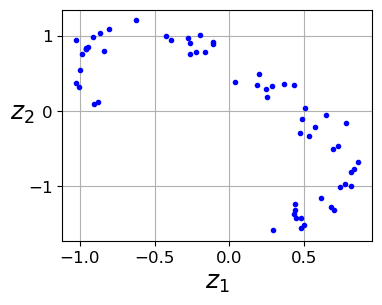

In [7]:
fig = plt.figure(figsize=(4,3))
plt.plot(codings[:,0], codings[:, 1], "b.")
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.grid(True)
plt.show()

### Stacked Autoencoders

In [8]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

#### Train all layers at once

In [9]:
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

In [10]:
tf.random.set_seed(42)
np.random.seed(42)

stacked_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="selu"),
])
stacked_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[30]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
stacked_ae = keras.models.Sequential([stacked_encoder, stacked_decoder])
stacked_ae.compile(loss="binary_crossentropy",
                   optimizer=keras.optimizers.SGD(learning_rate=1.5), metrics=[rounded_accuracy])
history = stacked_ae.fit(X_train, X_train, epochs=20,
                         validation_data=(X_valid, X_valid))

Epoch 1/20
1719/1719 [==============================] - 8s 4ms/step - loss: 0.3378 - rounded_accuracy: 0.8869 - val_loss: 0.3171 - val_rounded_accuracy: 0.8998
Epoch 2/20
1719/1719 [==============================] - 8s 4ms/step - loss: 0.3048 - rounded_accuracy: 0.9157 - val_loss: 0.3015 - val_rounded_accuracy: 0.9192
Epoch 3/20
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2977 - rounded_accuracy: 0.9221 - val_loss: 0.2989 - val_rounded_accuracy: 0.9184
Epoch 4/20
1719/1719 [==============================] - 8s 4ms/step - loss: 0.2934 - rounded_accuracy: 0.9260 - val_loss: 0.2936 - val_rounded_accuracy: 0.9261
Epoch 5/20
1719/1719 [==============================] - 8s 5ms/step - loss: 0.2907 - rounded_accuracy: 0.9284 - val_loss: 0.2905 - val_rounded_accuracy: 0.9302
Epoch 6/20
1719/1719 [==============================] - 8s 5ms/step - loss: 0.2887 - rounded_accuracy: 0.9302 - val_loss: 0.2891 - val_rounded_accuracy: 0.9322
Epoch 7/20
1719/1719 [==================

In [11]:
def show_reconstructions(model, images=X_valid, n_images=5):
    reconstructions = model.predict(images[:n_images])
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(images[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])

1/1 [==============================] - 0s 163ms/step


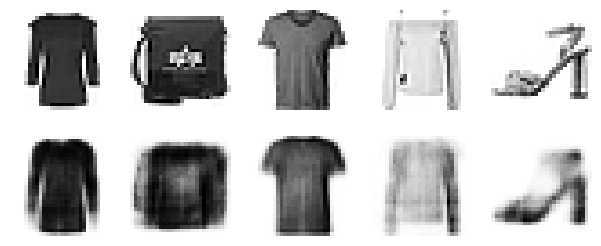

In [12]:
show_reconstructions(stacked_ae)

### Visualizing Fashion MNIST

In [20]:
# np.random.seed(42)

# from sklearn.manifold import TSNE

# X_valid_compressed = stacked_encoder.predict(X_valid)
# tsne = TSNE()
# X_valid_2D = tsne.fit_transform(X_valid_compressed)
# X_valid_2D = (X_valid_2D - X_valid_2D.min()) / (X_valid_2D.max() - X_valid_2D.min())

In [21]:
# plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=y_valid, s=10, cmap="tab10")
# plt.axis("off")
# plt.show()

In [22]:
# # adapted from https://scikit-learn.org/stable/auto_examples/manifold/plot_lle_digits.html
# plt.figure(figsize=(10, 8))
# cmap = plt.cm.tab10
# plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=y_valid, s=10, cmap=cmap)
# image_positions = np.array([[1., 1.]])
# for index, position in enumerate(X_valid_2D):
#     dist = np.sum((position - image_positions) ** 2, axis=1)
#     if np.min(dist) > 0.02: # if far enough from other images
#         image_positions = np.r_[image_positions, [position]]
#         imagebox = mpl.offsetbox.AnnotationBbox(
#             mpl.offsetbox.OffsetImage(X_valid[index], cmap="binary"),
#             position, bboxprops={"edgecolor": cmap(y_valid[index]), "lw": 2})
#         plt.gca().add_artist(imagebox)
# plt.axis("off")
# plt.show()

### Tying weights

In [23]:
class DenseTranspose(keras.layers.Layer):
    def __init__(self, dense, activation=None, **kwargs):
        self.dense = dense
        self.activation = keras.activations.get(activation)
        super().__init__(**kwargs)
    def build(self, batch_input_shape):
        self.biases = self.add_weight(name="bias",
                                      shape=[self.dense.input_shape[-1]],
                                      initializer="zeros")
        super().build(batch_input_shape)
    def call(self, inputs):
        z = tf.matmul(inputs, self.dense.weights[0], transpose_b=True)
        return self.activation(z + self.biases)

In [24]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

dense_1 = keras.layers.Dense(100, activation="selu")
dense_2 = keras.layers.Dense(30, activation="selu")

tied_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    dense_1,
    dense_2
])

tied_decoder = keras.models.Sequential([
    DenseTranspose(dense_2, activation="selu"),
    DenseTranspose(dense_1, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])

tied_ae = keras.models.Sequential([tied_encoder, tied_decoder])

tied_ae.compile(loss="binary_crossentropy",
                optimizer=keras.optimizers.SGD(learning_rate=1.5), metrics=[rounded_accuracy])
history = tied_ae.fit(X_train, X_train, epochs=10,
                      validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.3269 - rounded_accuracy: 0.8958 - val_loss: 0.3033 - val_rounded_accuracy: 0.9205
Epoch 2/10
1719/1719 [==============================] - 11s 7ms/step - loss: 0.2972 - rounded_accuracy: 0.9227 - val_loss: 0.2935 - val_rounded_accuracy: 0.9280
Epoch 3/10
1719/1719 [==============================] - 13s 7ms/step - loss: 0.2912 - rounded_accuracy: 0.9283 - val_loss: 0.2947 - val_rounded_accuracy: 0.9194
Epoch 4/10
1719/1719 [==============================] - 12s 7ms/step - loss: 0.2881 - rounded_accuracy: 0.9311 - val_loss: 0.2876 - val_rounded_accuracy: 0.9336
Epoch 5/10
1719/1719 [==============================] - 13s 7ms/step - loss: 0.2860 - rounded_accuracy: 0.9330 - val_loss: 0.2858 - val_rounded_accuracy: 0.9343
Epoch 6/10
1719/1719 [==============================] - 15s 8ms/step - loss: 0.2845 - rounded_accuracy: 0.9344 - val_loss: 0.2866 - val_rounded_accuracy: 0.9354
Epoch 7/10
1719/1719 [============

1/1 [==============================] - 0s 66ms/step


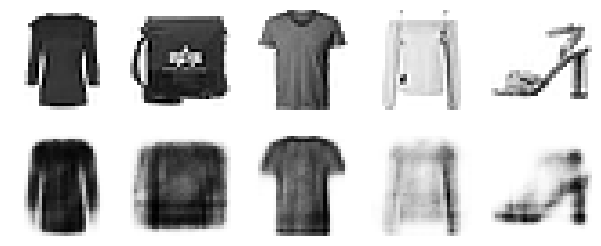

In [25]:
show_reconstructions(tied_ae)
plt.show()

### Training one Autoencoder at a Time

In [26]:
def train_autoencoder(n_neurons, X_train, X_valid, loss, optimizer,
                      n_epochs=10, output_activation=None, metrics=None):
    n_inputs = X_train.shape[-1]
    encoder = keras.models.Sequential([
        keras.layers.Dense(n_neurons, activation="selu", input_shape=[n_inputs])
    ])
    decoder = keras.models.Sequential([
        keras.layers.Dense(n_inputs, activation=output_activation),
    ])
    autoencoder = keras.models.Sequential([encoder, decoder])
    autoencoder.compile(optimizer, loss, metrics=metrics)
    autoencoder.fit(X_train, X_train, epochs=n_epochs,
                    validation_data=(X_valid, X_valid))
    return encoder, decoder, encoder(X_train), encoder(X_valid)

In [27]:
tf.random.set_seed(42)
np.random.seed(42)

K = keras.backend
X_train_flat = K.batch_flatten(X_train) # equivalent to .reshape(-1, 28 * 28)
X_valid_flat = K.batch_flatten(X_valid)
enc1, dec1, X_train_enc1, X_valid_enc1 = train_autoencoder(
    100, X_train_flat, X_valid_flat, "binary_crossentropy",
    keras.optimizers.SGD(learning_rate=1.5), output_activation="sigmoid",
    metrics=[rounded_accuracy])
enc2, dec2, _, _ = train_autoencoder(
    30, X_train_enc1, X_valid_enc1, "mse", keras.optimizers.SGD(learning_rate=0.05),
    output_activation="selu")

Epoch 1/10
1719/1719 [==============================] - 13s 7ms/step - loss: 0.3452 - rounded_accuracy: 0.8869 - val_loss: 0.3114 - val_rounded_accuracy: 0.9158
Epoch 2/10
1719/1719 [==============================] - 13s 7ms/step - loss: 0.3029 - rounded_accuracy: 0.9214 - val_loss: 0.2996 - val_rounded_accuracy: 0.9255
Epoch 3/10
1719/1719 [==============================] - 13s 8ms/step - loss: 0.2941 - rounded_accuracy: 0.9295 - val_loss: 0.2926 - val_rounded_accuracy: 0.9325
Epoch 4/10
1719/1719 [==============================] - 12s 7ms/step - loss: 0.2885 - rounded_accuracy: 0.9348 - val_loss: 0.2882 - val_rounded_accuracy: 0.9370
Epoch 5/10
1719/1719 [==============================] - 14s 8ms/step - loss: 0.2848 - rounded_accuracy: 0.9384 - val_loss: 0.2852 - val_rounded_accuracy: 0.9398
Epoch 6/10
1719/1719 [==============================] - 13s 8ms/step - loss: 0.2822 - rounded_accuracy: 0.9409 - val_loss: 0.2829 - val_rounded_accuracy: 0.9416
Epoch 7/10
1719/1719 [============

In [29]:
stacked_ae_1_by_1 = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    enc1, enc2, dec2, dec1,
    keras.layers.Reshape([28, 28])
])

1/1 [==============================] - 0s 124ms/step


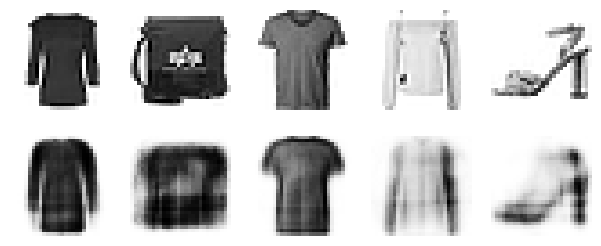

In [30]:
show_reconstructions(stacked_ae_1_by_1)
plt.show()

In [31]:
stacked_ae_1_by_1.compile(loss="binary_crossentropy",
                          optimizer=keras.optimizers.SGD(learning_rate=0.1), metrics=[rounded_accuracy])
history = stacked_ae_1_by_1.fit(X_train, X_train, epochs=10,
                                validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 8s 4ms/step - loss: 0.2866 - rounded_accuracy: 0.9344 - val_loss: 0.2882 - val_rounded_accuracy: 0.9347
Epoch 2/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.2862 - rounded_accuracy: 0.9349 - val_loss: 0.2879 - val_rounded_accuracy: 0.9348
Epoch 3/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2859 - rounded_accuracy: 0.9352 - val_loss: 0.2876 - val_rounded_accuracy: 0.9349
Epoch 4/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.2857 - rounded_accuracy: 0.9354 - val_loss: 0.2875 - val_rounded_accuracy: 0.9354
Epoch 5/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2855 - rounded_accuracy: 0.9355 - val_loss: 0.2873 - val_rounded_accuracy: 0.9355
Epoch 6/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.2854 - rounded_accuracy: 0.9357 - val_loss: 0.2872 - val_rounded_accuracy: 0.9353
Epoch 7/10
1719/1719 [==================

1/1 [==============================] - 0s 76ms/step


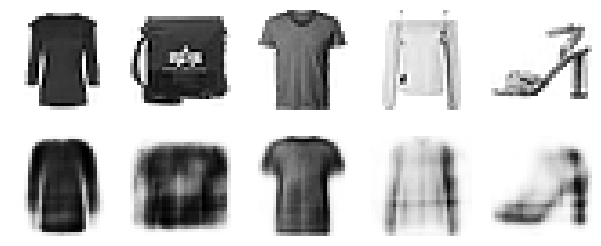

In [32]:
show_reconstructions(stacked_ae_1_by_1)
plt.show()

### Using Convolutional Layers Instead of Dense Layers

In [33]:
tf.random.set_seed(42)
np.random.seed(42)

conv_encoder = keras.models.Sequential([
    keras.layers.Reshape([28, 28, 1], input_shape=[28, 28]),
    keras.layers.Conv2D(16, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(32, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(64, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2)
])
conv_decoder = keras.models.Sequential([
    keras.layers.Conv2DTranspose(32, kernel_size=3, strides=2, padding="VALID", activation="selu",
                                 input_shape=[3, 3, 64]),
    keras.layers.Conv2DTranspose(16, kernel_size=3, strides=2, padding="SAME", activation="selu"),
    keras.layers.Conv2DTranspose(1, kernel_size=3, strides=2, padding="SAME", activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
conv_ae = keras.models.Sequential([conv_encoder, conv_decoder])

conv_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=1.0),
                metrics=[rounded_accuracy])
history = conv_ae.fit(X_train, X_train, epochs=5,
                      validation_data=(X_valid, X_valid))

Epoch 1/5
1719/1719 [==============================] - 48s 27ms/step - loss: 0.3010 - rounded_accuracy: 0.9191 - val_loss: 0.2840 - val_rounded_accuracy: 0.9308
Epoch 2/5
1719/1719 [==============================] - 75s 43ms/step - loss: 0.2755 - rounded_accuracy: 0.9414 - val_loss: 0.2727 - val_rounded_accuracy: 0.9467
Epoch 3/5
1719/1719 [==============================] - 72s 42ms/step - loss: 0.2710 - rounded_accuracy: 0.9458 - val_loss: 0.2783 - val_rounded_accuracy: 0.9322
Epoch 4/5
1719/1719 [==============================] - 69s 40ms/step - loss: 0.2685 - rounded_accuracy: 0.9483 - val_loss: 0.2677 - val_rounded_accuracy: 0.9510
Epoch 5/5
1719/1719 [==============================] - 64s 37ms/step - loss: 0.2666 - rounded_accuracy: 0.9503 - val_loss: 0.2667 - val_rounded_accuracy: 0.9516


In [34]:
conv_encoder.summary()
conv_decoder.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_3 (Reshape)         (None, 28, 28, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 7, 7, 32)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 64)        

1/1 [==============================] - 0s 292ms/step


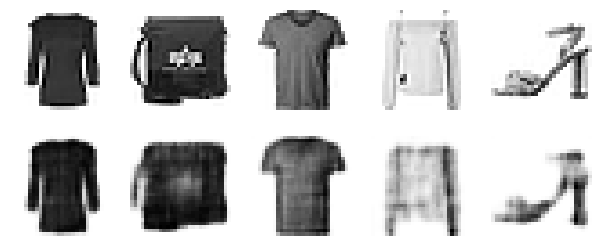

In [35]:
show_reconstructions(conv_ae)
plt.show()

### Recurrent Autoencoders

In [36]:
recurrent_encoder = keras.models.Sequential([
    keras.layers.LSTM(100, return_sequences=True, input_shape=[28, 28]),
    keras.layers.LSTM(30)
])
recurrent_decoder = keras.models.Sequential([
    keras.layers.RepeatVector(28, input_shape=[30]),
    keras.layers.LSTM(100, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(28, activation="sigmoid"))
])
recurrent_ae = keras.models.Sequential([recurrent_encoder, recurrent_decoder])
recurrent_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(0.1),
                     metrics=[rounded_accuracy])

In [37]:
history = recurrent_ae.fit(X_train, X_train, epochs=10, validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 116s 64ms/step - loss: 0.4969 - rounded_accuracy: 0.7700 - val_loss: 0.4226 - val_rounded_accuracy: 0.8258
Epoch 2/10
1719/1719 [==============================] - 111s 65ms/step - loss: 0.3913 - rounded_accuracy: 0.8506 - val_loss: 0.3748 - val_rounded_accuracy: 0.8652
Epoch 3/10
1719/1719 [==============================] - 132s 77ms/step - loss: 0.3633 - rounded_accuracy: 0.8716 - val_loss: 0.3595 - val_rounded_accuracy: 0.8755
Epoch 4/10
1719/1719 [==============================] - 136s 79ms/step - loss: 0.3510 - rounded_accuracy: 0.8817 - val_loss: 0.3540 - val_rounded_accuracy: 0.8796
Epoch 5/10
1719/1719 [==============================] - 136s 79ms/step - loss: 0.3413 - rounded_accuracy: 0.8881 - val_loss: 0.3391 - val_rounded_accuracy: 0.8889
Epoch 6/10
1719/1719 [==============================] - 164s 95ms/step - loss: 0.3333 - rounded_accuracy: 0.8927 - val_loss: 0.3318 - val_rounded_accuracy: 0.8953
Epoch 7/10
1719/1719 [

1/1 [==============================] - 1s 1s/step


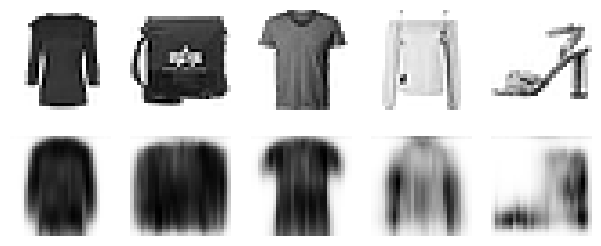

In [38]:
show_reconstructions(recurrent_ae)
plt.show()

### Stacked denoising Autoencoder 

In [39]:
tf.random.set_seed(42)
np.random.seed(42)

denoising_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.GaussianNoise(0.2),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="selu")
])
denoising_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[30]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
denoising_ae = keras.models.Sequential([denoising_encoder, denoising_decoder])
denoising_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=1.0),
                     metrics=[rounded_accuracy])
history = denoising_ae.fit(X_train, X_train, epochs=10,
                           validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3485 - rounded_accuracy: 0.8781 - val_loss: 0.3183 - val_rounded_accuracy: 0.9040
Epoch 2/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3121 - rounded_accuracy: 0.9097 - val_loss: 0.3091 - val_rounded_accuracy: 0.9162
Epoch 3/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3053 - rounded_accuracy: 0.9156 - val_loss: 0.3038 - val_rounded_accuracy: 0.9155
Epoch 4/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3014 - rounded_accuracy: 0.9190 - val_loss: 0.2990 - val_rounded_accuracy: 0.9225
Epoch 5/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.2986 - rounded_accuracy: 0.9214 - val_loss: 0.2967 - val_rounded_accuracy: 0.9241
Epoch 6/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.2965 - rounded_accuracy: 0.9232 - val_loss: 0.2956 - val_rounded_accuracy: 0.9277
Epoch 7/10
1719/1719 [==================

1/1 [==============================] - 0s 107ms/step


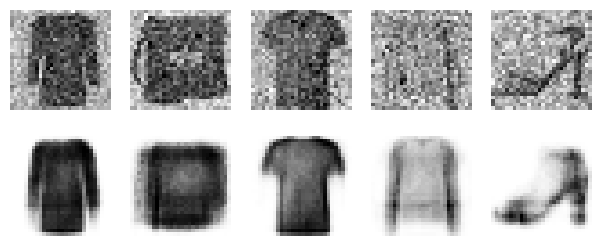

In [40]:
tf.random.set_seed(42)
np.random.seed(42)

noise = keras.layers.GaussianNoise(0.2)
show_reconstructions(denoising_ae, noise(X_valid, training=True))
plt.show()

#### using dropout: 

In [41]:
tf.random.set_seed(42)
np.random.seed(42)

dropout_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="selu")
])
dropout_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[30]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
dropout_ae = keras.models.Sequential([dropout_encoder, dropout_decoder])
dropout_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=1.0),
                   metrics=[rounded_accuracy])
history = dropout_ae.fit(X_train, X_train, epochs=10,
                         validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3589 - rounded_accuracy: 0.8697 - val_loss: 0.3218 - val_rounded_accuracy: 0.9040
Epoch 2/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3206 - rounded_accuracy: 0.9012 - val_loss: 0.3146 - val_rounded_accuracy: 0.9081
Epoch 3/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3155 - rounded_accuracy: 0.9051 - val_loss: 0.3106 - val_rounded_accuracy: 0.9113
Epoch 4/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3120 - rounded_accuracy: 0.9078 - val_loss: 0.3080 - val_rounded_accuracy: 0.9148
Epoch 5/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3096 - rounded_accuracy: 0.9096 - val_loss: 0.3055 - val_rounded_accuracy: 0.9157
Epoch 6/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3077 - rounded_accuracy: 0.9110 - val_loss: 0.3045 - val_rounded_accuracy: 0.9148
Epoch 7/10
1719/1719 [==================

1/1 [==============================] - 0s 38ms/step


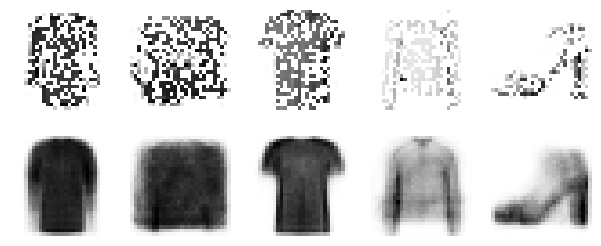

In [43]:
tf.random.set_seed(42)
np.random.seed(42)

dropout = keras.layers.Dropout(0.5)
show_reconstructions(dropout_ae, dropout(X_valid, training=True))

### Sparse Autoencoder

In [44]:
tf.random.set_seed(42)
np.random.seed(42)

simple_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="sigmoid"),
])
simple_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[30]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
simple_ae = keras.models.Sequential([simple_encoder, simple_decoder])
simple_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=1.),
                  metrics=[rounded_accuracy])
history = simple_ae.fit(X_train, X_train, epochs=10,
                        validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.4370 - rounded_accuracy: 0.7938 - val_loss: 0.3766 - val_rounded_accuracy: 0.8491
Epoch 2/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.3588 - rounded_accuracy: 0.8699 - val_loss: 0.3482 - val_rounded_accuracy: 0.8828
Epoch 3/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3368 - rounded_accuracy: 0.8900 - val_loss: 0.3307 - val_rounded_accuracy: 0.8941
Epoch 4/10
1719/1719 [==============================] - 8s 4ms/step - loss: 0.3242 - rounded_accuracy: 0.8997 - val_loss: 0.3231 - val_rounded_accuracy: 0.9024
Epoch 5/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3194 - rounded_accuracy: 0.9027 - val_loss: 0.3197 - val_rounded_accuracy: 0.9030
Epoch 6/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3164 - rounded_accuracy: 0.9048 - val_loss: 0.3168 - val_rounded_accuracy: 0.9069
Epoch 7/10
1719/1719 [==================

1/1 [==============================] - 0s 110ms/step


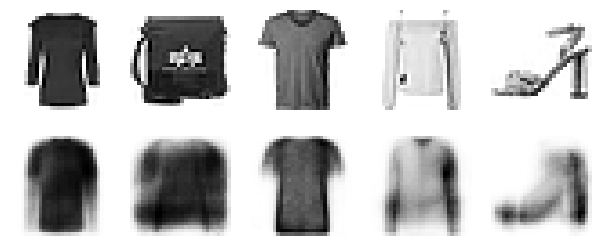

In [45]:
show_reconstructions(simple_ae)
plt.show()

In [46]:
def plot_percent_hist(ax, data, bins):
    counts, _ = np.histogram(data, bins=bins)
    widths = bins[1:] - bins[:-1]
    x = bins[:-1] + widths / 2
    ax.bar(x, counts / len(data), width=widths*0.8)
    ax.xaxis.set_ticks(bins)
    ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(
        lambda y, position: "{}%".format(int(np.round(100 * y)))))
    ax.grid(True)

In [47]:
def plot_activations_histogram(encoder, height=1, n_bins=10):
    X_valid_codings = encoder(X_valid).numpy()
    activation_means = X_valid_codings.mean(axis=0)
    mean = activation_means.mean()
    bins = np.linspace(0, 1, n_bins + 1)

    fig, [ax1, ax2] = plt.subplots(figsize=(10, 3), nrows=1, ncols=2, sharey=True)
    plot_percent_hist(ax1, X_valid_codings.ravel(), bins)
    ax1.plot([mean, mean], [0, height], "k--", label="Overall Mean = {:.2f}".format(mean))
    ax1.legend(loc="upper center", fontsize=14)
    ax1.set_xlabel("Activation")
    ax1.set_ylabel("% Activations")
    ax1.axis([0, 1, 0, height])
    plot_percent_hist(ax2, activation_means, bins)
    ax2.plot([mean, mean], [0, height], "k--")
    ax2.set_xlabel("Neuron Mean Activation")
    ax2.set_ylabel("% Neurons")
    ax2.axis([0, 1, 0, height])

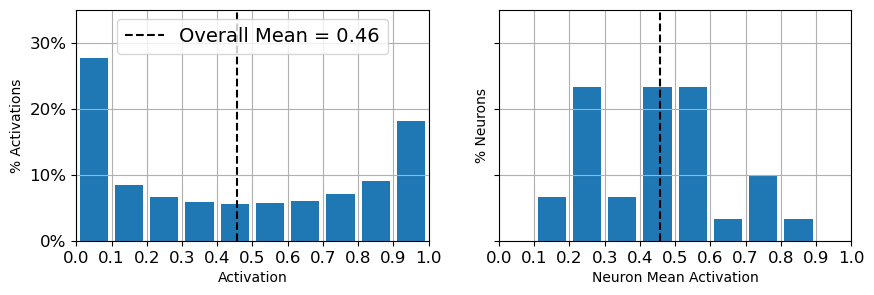

In [48]:
plot_activations_histogram(simple_encoder, height=0.35)
plt.show()

In [49]:
tf.random.set_seed(42)
np.random.seed(42)

sparse_l1_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(300, activation="sigmoid"),
    keras.layers.ActivityRegularization(l1=1e-3)  # Alternatively, you could add
                                                  # activity_regularizer=keras.regularizers.l1(1e-3)
                                                  # to the previous layer.
])
sparse_l1_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[300]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
sparse_l1_ae = keras.models.Sequential([sparse_l1_encoder, sparse_l1_decoder])
sparse_l1_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=1.0),
                     metrics=[rounded_accuracy])
history = sparse_l1_ae.fit(X_train, X_train, epochs=10,
                           validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.4356 - rounded_accuracy: 0.8096 - val_loss: 0.3813 - val_rounded_accuracy: 0.8550
Epoch 2/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3701 - rounded_accuracy: 0.8673 - val_loss: 0.3651 - val_rounded_accuracy: 0.8743
Epoch 3/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3563 - rounded_accuracy: 0.8785 - val_loss: 0.3531 - val_rounded_accuracy: 0.8789
Epoch 4/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3461 - rounded_accuracy: 0.8851 - val_loss: 0.3449 - val_rounded_accuracy: 0.8889
Epoch 5/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.3397 - rounded_accuracy: 0.8891 - val_loss: 0.3396 - val_rounded_accuracy: 0.8927
Epoch 6/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3349 - rounded_accuracy: 0.8928 - val_loss: 0.3347 - val_rounded_accuracy: 0.8929
Epoch 7/10
1719/1719 [=================

1/1 [==============================] - 0s 77ms/step


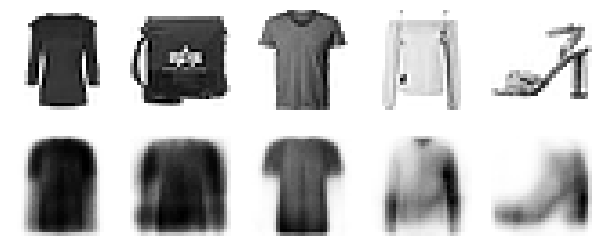

In [50]:
show_reconstructions(sparse_l1_ae)

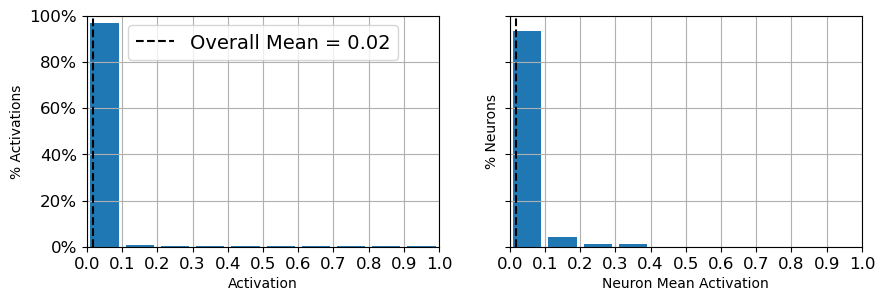

In [51]:
plot_activations_histogram(sparse_l1_encoder, height=1.)
plt.show()

(0.0, 1.0, 0.0, 0.95)

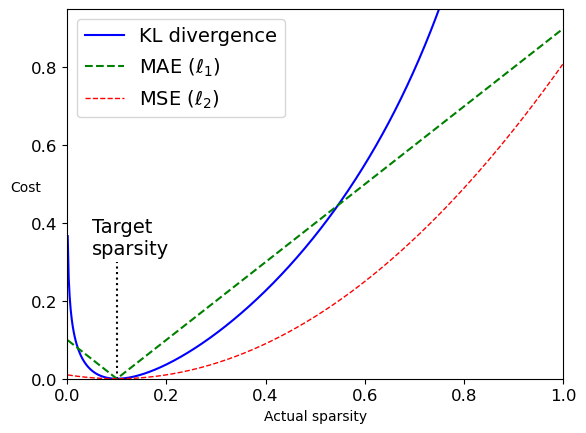

In [53]:
p = 0.1
q = np.linspace(0.001, 0.999, 500)
kl_div = p * np.log(p / q) + (1 - p) * np.log((1 - p) / (1 - q))
mse = (p - q)**2
mae = np.abs(p - q)
plt.plot([p, p], [0, 0.3], "k:")
plt.text(0.05, 0.32, "Target\nsparsity", fontsize=14)
plt.plot(q, kl_div, "b-", label="KL divergence")
plt.plot(q, mae, "g--", label=r"MAE ($\ell_1$)")
plt.plot(q, mse, "r--", linewidth=1, label=r"MSE ($\ell_2$)")
plt.legend(loc="upper left", fontsize=14)
plt.xlabel("Actual sparsity")
plt.ylabel("Cost", rotation=0)
plt.axis([0, 1, 0, 0.95])

In [54]:
K = keras.backend
kl_divergence = keras.losses.kullback_leibler_divergence

class KLDivergenceRegularizer(keras.regularizers.Regularizer):
    def __init__(self, weight, target=0.1):
        self.weight = weight
        self.target = target
    def __call__(self, inputs):
        mean_activities = K.mean(inputs, axis=0)
        return self.weight * (
            kl_divergence(self.target, mean_activities) +
            kl_divergence(1. - self.target, 1. - mean_activities))

In [55]:
tf.random.set_seed(42)
np.random.seed(42)

kld_reg = KLDivergenceRegularizer(weight=0.05, target=0.1)
sparse_kl_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(300, activation="sigmoid", activity_regularizer=kld_reg)
])
sparse_kl_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[300]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
sparse_kl_ae = keras.models.Sequential([sparse_kl_encoder, sparse_kl_decoder])
sparse_kl_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=1.0),
              metrics=[rounded_accuracy])
history = sparse_kl_ae.fit(X_train, X_train, epochs=10,
                           validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 11s 6ms/step - loss: 0.4148 - rounded_accuracy: 0.8146 - val_loss: 0.3692 - val_rounded_accuracy: 0.8620
Epoch 2/10
1719/1719 [==============================] - 8s 4ms/step - loss: 0.3514 - rounded_accuracy: 0.8785 - val_loss: 0.3425 - val_rounded_accuracy: 0.8865
Epoch 3/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3323 - rounded_accuracy: 0.8935 - val_loss: 0.3273 - val_rounded_accuracy: 0.8995
Epoch 4/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3212 - rounded_accuracy: 0.9029 - val_loss: 0.3206 - val_rounded_accuracy: 0.9048
Epoch 5/10
1719/1719 [==============================] - 13s 8ms/step - loss: 0.3165 - rounded_accuracy: 0.9066 - val_loss: 0.3170 - val_rounded_accuracy: 0.9080
Epoch 6/10
1719/1719 [==============================] - 14s 8ms/step - loss: 0.3133 - rounded_accuracy: 0.9094 - val_loss: 0.3139 - val_rounded_accuracy: 0.9102
Epoch 7/10
1719/1719 [===============

1/1 [==============================] - 0s 108ms/step


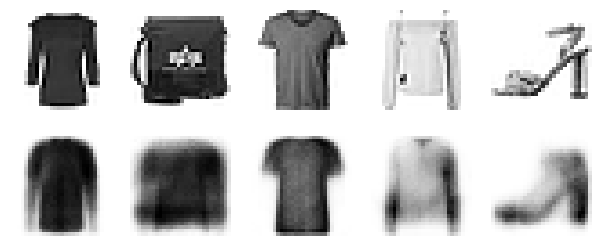

In [56]:
show_reconstructions(sparse_kl_ae)

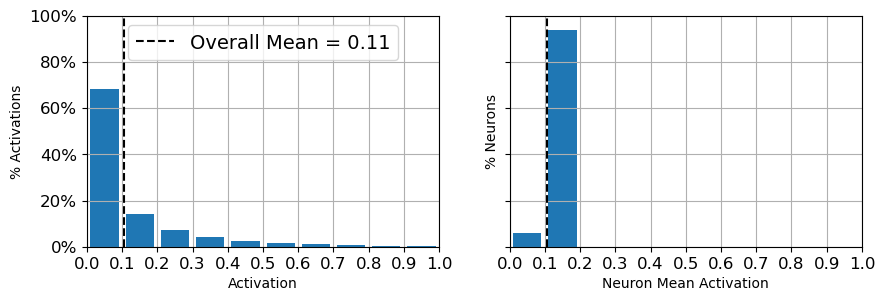

In [57]:
plot_activations_histogram(sparse_kl_encoder)
plt.show()

### Variational Autoencoder

In [58]:
class Sampling(keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return K.random_normal(tf.shape(log_var)) * K.exp(log_var / 2) + mean 

In [59]:
tf.random.set_seed(42)
np.random.seed(42)

codings_size = 10

inputs = keras.layers.Input(shape=[28, 28])
z = keras.layers.Flatten()(inputs)
z = keras.layers.Dense(150, activation="selu")(z)
z = keras.layers.Dense(100, activation="selu")(z)
codings_mean = keras.layers.Dense(codings_size)(z)
codings_log_var = keras.layers.Dense(codings_size)(z)
codings = Sampling()([codings_mean, codings_log_var])
variational_encoder = keras.models.Model(
    inputs=[inputs], outputs=[codings_mean, codings_log_var, codings])

decoder_inputs = keras.layers.Input(shape=[codings_size])
x = keras.layers.Dense(100, activation="selu")(decoder_inputs)
x = keras.layers.Dense(150, activation="selu")(x)
x = keras.layers.Dense(28 * 28, activation="sigmoid")(x)
outputs = keras.layers.Reshape([28, 28])(x)
variational_decoder = keras.models.Model(inputs=[decoder_inputs], outputs=[outputs])

_, _, codings = variational_encoder(inputs)
reconstructions = variational_decoder(codings)
variational_ae = keras.models.Model(inputs=[inputs], outputs=[reconstructions])

latent_loss = -0.5 * K.sum(
    1 + codings_log_var - K.exp(codings_log_var) - K.square(codings_mean),
    axis=-1)
variational_ae.add_loss(K.mean(latent_loss) / 784.)
variational_ae.compile(loss="binary_crossentropy", optimizer="rmsprop", metrics=[rounded_accuracy])
history = variational_ae.fit(X_train, X_train, epochs=25, batch_size=128,
                             validation_data=(X_valid, X_valid))

Epoch 1/25
430/430 [==============================] - 6s 11ms/step - loss: 0.4126 - rounded_accuracy: 0.8363 - val_loss: 0.3762 - val_rounded_accuracy: 0.8606
Epoch 2/25
430/430 [==============================] - 4s 10ms/step - loss: 0.3560 - rounded_accuracy: 0.8891 - val_loss: 0.3503 - val_rounded_accuracy: 0.8936
Epoch 3/25
430/430 [==============================] - 6s 14ms/step - loss: 0.3442 - rounded_accuracy: 0.8978 - val_loss: 0.3423 - val_rounded_accuracy: 0.8982
Epoch 4/25
430/430 [==============================] - 5s 12ms/step - loss: 0.3381 - rounded_accuracy: 0.9022 - val_loss: 0.3358 - val_rounded_accuracy: 0.9039
Epoch 5/25
430/430 [==============================] - 5s 12ms/step - loss: 0.3338 - rounded_accuracy: 0.9052 - val_loss: 0.3359 - val_rounded_accuracy: 0.9007
Epoch 6/25
430/430 [==============================] - 6s 13ms/step - loss: 0.3307 - rounded_accuracy: 0.9073 - val_loss: 0.3316 - val_rounded_accuracy: 0.9051
Epoch 7/25
430/430 [==========================

1/1 [==============================] - 0s 132ms/step


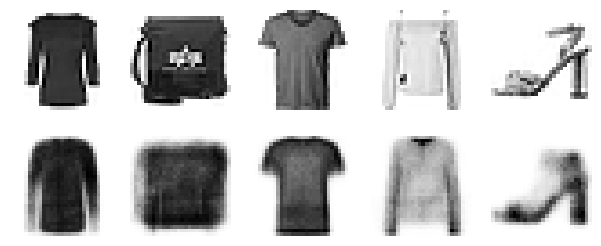

In [60]:
show_reconstructions(variational_ae)
plt.show()

### Generating Fashion MNIST Images 